In [1]:
import json
from ML4IR_components import *
import pickle
import matplotlib.pyplot as plt
from enum import Enum, auto

class Mode(Enum):
    TRAIN = auto()  # Trains a model
    TRAIN_SAVE = auto()  # Trains and saves a model
    LOAD = auto()  # Loads the saved model

# Change this variable to swap between different behaviours
MODE = Mode.LOAD

In [2]:
if MODE is Mode.TRAIN or MODE is Mode.TRAIN_SAVE:
    def load_smiles(filename):
        nruter = dict()
        with open(filename, "r") as f:
            for l in f:
                fields = l.split()
                if len(fields) == 2:
                    nruter[int(fields[0])] = fields[1]
        return nruter

    smiles_data = load_smiles("smiles.txt")  # File containing SMILES and IDs of molecules
    targets_data = json.load(open("spectra.json", "r"))  # File containing IDs of molecules and the spectra
    ids = np.array(sorted(list(smiles_data.keys())))

    smiles = []
    targets = []
    bans = []
    ID_list = []
    for i in range(len(ids)):
        if smiles_data[ids[i]] in bans:
            continue
        if smiles_data[ids[i]] in smiles:
            removeindex = smiles.index(smiles_data[ids[i]])
            smiles.pop(removeindex)
            targets.pop(removeindex)
            ID_list.pop(removeindex)
            bans.append(smiles_data[ids[i]])
            continue
        smiles.append(smiles_data[ids[i]])
        targets.append(targets_data[str(ids[i])])
        ID_list.append(ids[i])
    
    print("Number of molecules: ", len(ID_list))
    
    DATA = GenerateDATA(np.array(smiles), np.array(targets)[:, :105], radius = 11)
    print("Number of fragments: ", len(DATA["IDs"]))
    model = TrainModel(DATA, [1500,1000,800,650], EMDloss)
    
    if MODE is Mode.TRAIN_SAVE:
        model.save("MODEL_n")
        with open("MODEL_n.pck","wb") as f:
            pickle.dump(model, f)

Number of molecules:  2670
Number of fragments:  6388


2024-09-05 15:22:52.146754: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-09-05 15:22:52.146776: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-09-05 15:22:52.146790: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (autodl-container-2dee449d7f-2da48549): /proc/driver/nvidia/version does not exist
2024-09-05 15:22:52.147101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/r

Epoch 1/999999
75/75 [==============================] - 2s 23ms/step - loss: 124.2956 - val_loss: 79.4139
Epoch 2/999999
75/75 [==============================] - 2s 22ms/step - loss: 73.4588 - val_loss: 68.9736
Epoch 3/999999
75/75 [==============================] - 2s 22ms/step - loss: 65.8175 - val_loss: 66.2881
Epoch 4/999999
75/75 [==============================] - 2s 20ms/step - loss: 59.7782 - val_loss: 65.0103
Epoch 5/999999
75/75 [==============================] - 1s 16ms/step - loss: 55.9145 - val_loss: 65.0918
Epoch 6/999999
75/75 [==============================] - 1s 16ms/step - loss: 52.0508 - val_loss: 64.8062
Epoch 7/999999
75/75 [==============================] - 1s 15ms/step - loss: 48.6701 - val_loss: 65.3304
Epoch 8/999999
75/75 [==============================] - 1s 18ms/step - loss: 45.7265 - val_loss: 63.8257
Epoch 9/999999
75/75 [==============================] - 1s 19ms/step - loss: 44.4990 - val_loss: 63.9004
Epoch 10/999999
75/75 [==============================]

In [2]:
if MODE is Mode.LOAD:
    DATA = pickle.load(open("DATA.pck", "rb"))
    model = keras.models.load_model("MODEL", custom_objects={ 'EMDloss': EMDloss, 'K': K })
    DATA_1 = pickle.load(open("DATA_1.pck", "rb"))
    model_1 = keras.models.load_model("MODEL_1", custom_objects={ 'EMDloss': EMDloss, 'K': K })
    DATA_2 = pickle.load(open("DATA_2.pck", "rb"))
    model_2 = keras.models.load_model("MODEL_2", custom_objects={ 'EMDloss': EMDloss, 'K': K })
    DATA_3 = pickle.load(open("DATA_3.pck", "rb"))
    model_3 = keras.models.load_model("MODEL_3", custom_objects={ 'EMDloss': EMDloss, 'K': K })

13/13 [==============================] - 0s 10ms/step


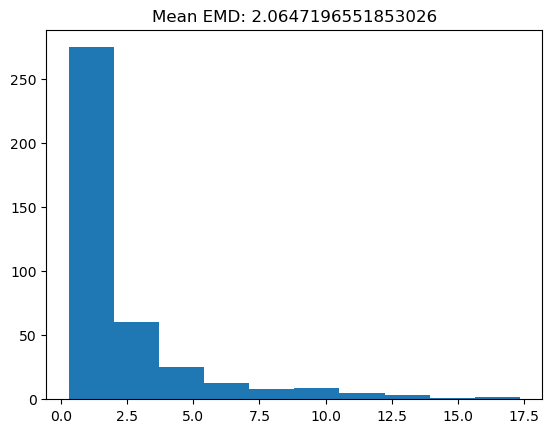

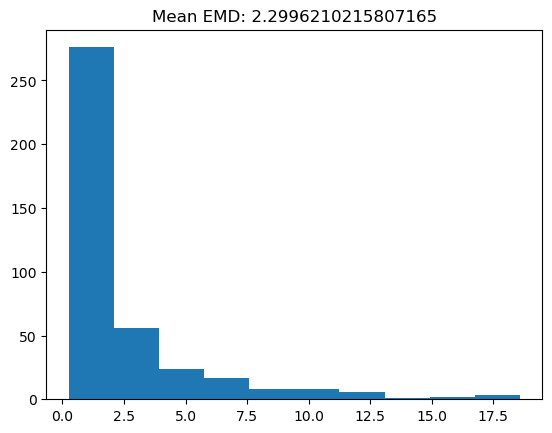

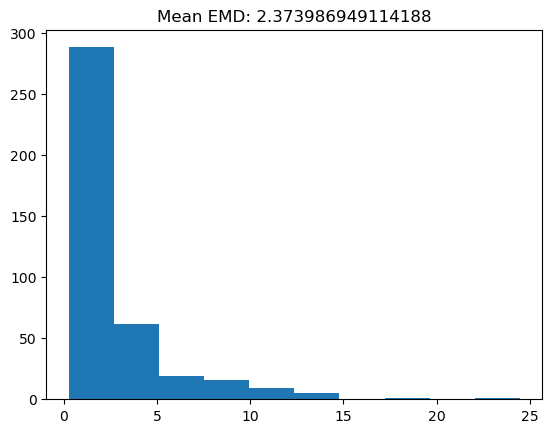

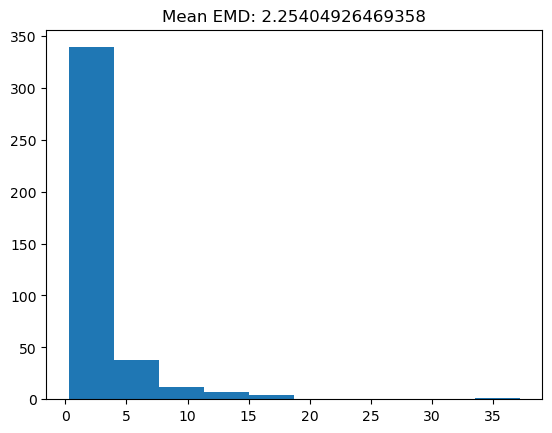

In [3]:
def PlotHist(DATA, model):
    plt.figure()
    preds = model.predict(DATA["X_test"])
    preds = preds/np.sum(preds,axis=1)[:,np.newaxis]
    Y = DATA["Y_test"]
    Y = Y/np.sum(Y,axis=1)[:,np.newaxis]
    
    EMDs = np.sum(np.abs(np.cumsum(Y-preds, axis = 1)), axis=1)
    
    plt.hist(EMDs)
    plt.title("Mean EMD: "+str(np.mean(EMDs)))
    
    return EMDs

_=PlotHist(DATA, model)
_=PlotHist(DATA_1, model_1)
_=PlotHist(DATA_2, model_2)
_=PlotHist(DATA_3, model_3)

In [4]:
def PredictFromSMILES(smiles, DATA, model):
    X = GenerateFP(smiles, DATA["IDs"])

    Y_pred = model.predict(X.reshape(1,-1))
    Y_pred = Y_pred / np.sum(Y_pred)
    
    return Y_pred.flatten()

1/1 [==============================] - 0s 17ms/step


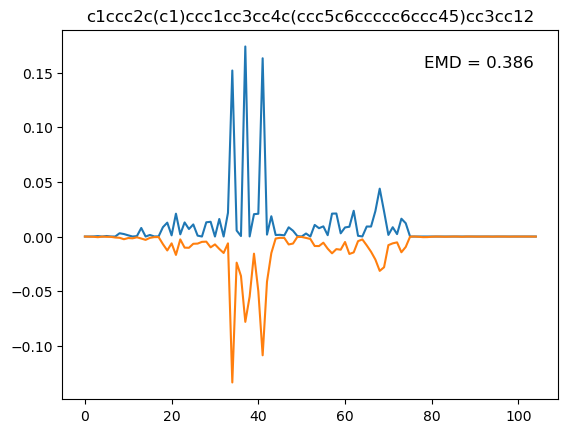

In [19]:
example_idx = 0
examplesmiles = DATA_3["smiles_test"][example_idx]

Y_pred = PredictFromSMILES(examplesmiles, DATA, model)

Y = DATA_3["Y_test"][example_idx]
Y = Y/np.sum(Y)

loss_EMD = round(np.sum(np.abs(np.cumsum(Y-Y_pred))), 3)

plt.title(examplesmiles)
plt.plot(Y)
plt.plot(-Y_pred)
plt.text(0.95, 0.93, f'EMD = {loss_EMD}', horizontalalignment='right', verticalalignment='top', 
         transform=plt.gca().transAxes, fontsize=12)
plt.show()